## AI tool for Akaraka
The coding below is the main coding part to develop a AI/Machine Learning model for Akaraka users' to classify the intent;  

The whole development will include:  

    1. Train a model to classify the intent (Key delivery: when user input a setence, the model will identify the intent; the accuracy upto 95% when possible)  

    2. Once the intent is indenfied, the system will give the feedback

### 1. Load the dataset

In [3]:
#import neccessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from wordcloud import WordCloud
from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#install necessary models
!python -m spacy download en_core_web_sm
!pip install wordcloud
!pip install spacy


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------ --------------------------- 3.9/12.8 MB 19.6 MB/s eta 0:00:01
     ------------------------- -------------- 8.1/12.8 MB 21.0 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 21.1 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 17.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 14.9 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


ERROR: unknown command "isnstall" - maybe you meant "install"



Defaulting to user installation because normal site-packages is not writeable


In [4]:
#import data set 
path = "assessment.csv"
df = pd.read_csv(path)

df.head()

,#,Setence,Intent
0,1,I want to post the assessment brief.,Post assessment brief
1,2,I need to upload the assignment details.,Post assessment brief
2,3,Show me how to post the assignment brief.,Post assessment brief
3,4,I want to create an assignment brief for stude...,Post assessment brief
4,5,Where can I upload the assessment information?,Post assessment brief


### 2. Pre-process, clean data and EDA

In this demo dataset, we only have two label intent" "Post assessment brief" and "Create assessment submission link"

In [5]:
#set the stop words. Stop words are common words that do not add much meaning to a sentence.
nlp = spacy.load("en_core_web_sm")
stop_words = STOP_WORDS

#create a function to tokenize the text, and remove stop words in the sentences
def tokenize(text):
    token = nlp(text)
    tokens = [word.lemma_.lower().strip() for word in token if word.lemma_ != "-PRON-"]
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return tokens


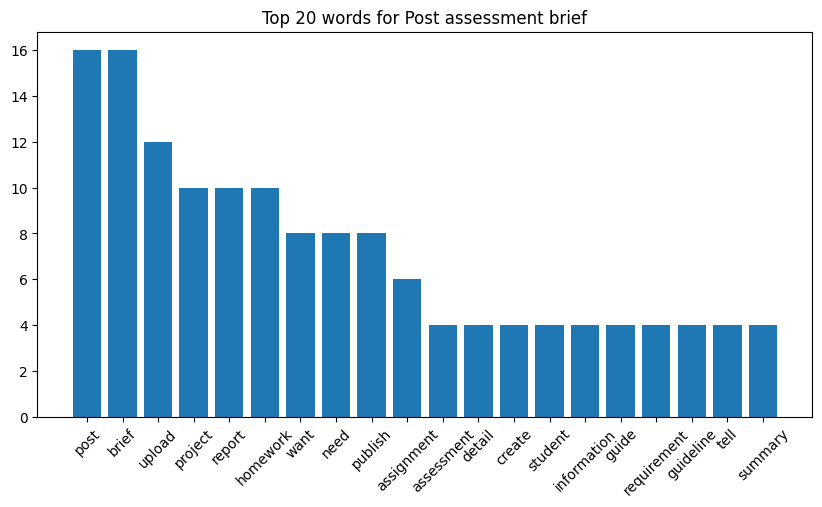

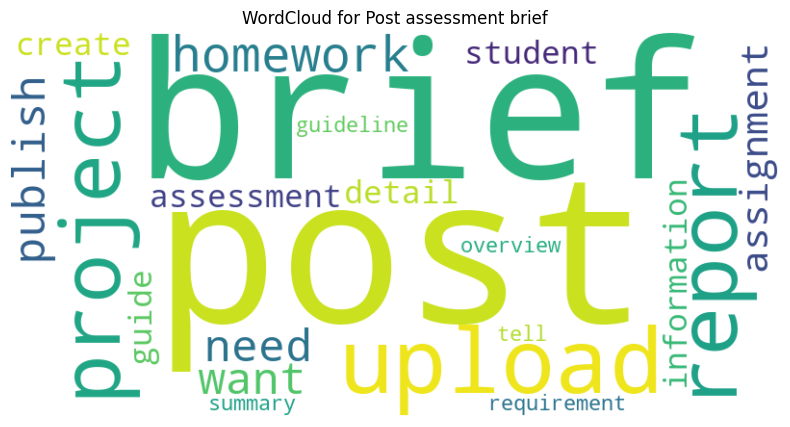

****************************************************************************************************


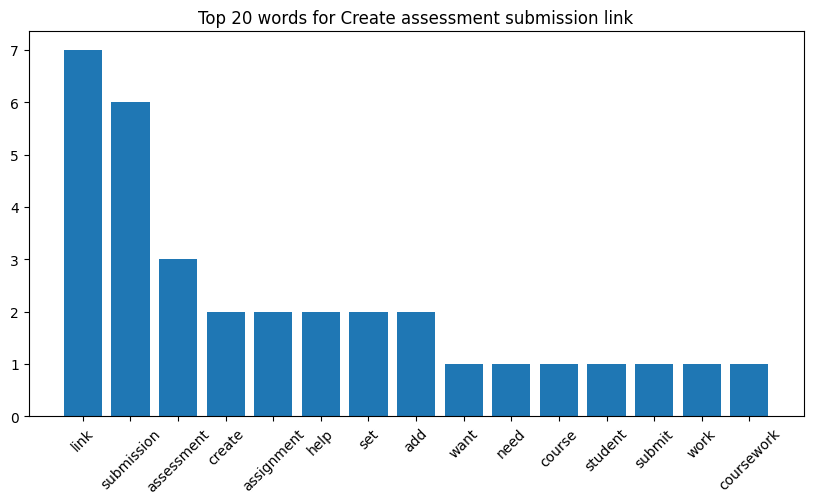

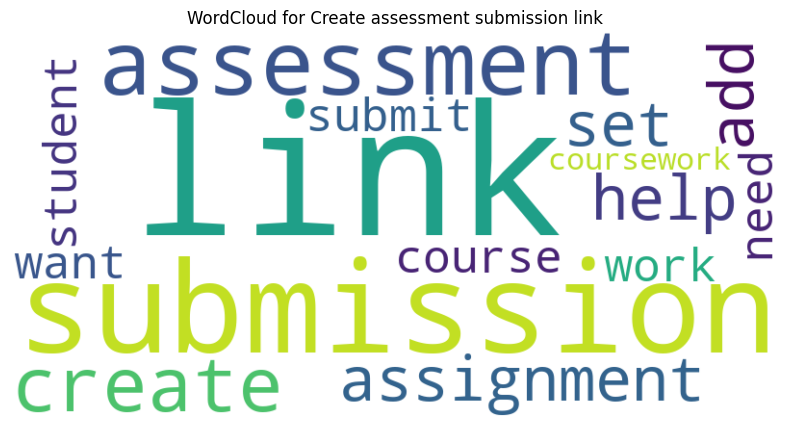

****************************************************************************************************


In [11]:
#apply the tokenize function to the sentences in the dataframe
for intent in df['Intent'].unique():
    subset = df[df['Intent'] == intent]['Setence']

    tokens = []
    for sentence in subset:
        tokens.extend(tokenize(sentence))

    counter = Counter(tokens)
    common_words = counter.most_common(20)

    #create bar chart for each intent 
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(f'Top 20 words for {intent}')
    plt.show()
    
    #create word cloud map for each intent
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate_from_frequencies(counter)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {intent}')
    plt.show()

    print("*" *100)

From the chart above, we can conclude the following:  

1. For the Post Assessment Brief intent, the words “post”, “brief”, and “upload” occur most frequently. This indicates that if a sentence includes one or more of these keywords (or their combinations), it is more likely to be identified as Post Assessment Brief.  

2. For the Create Assessment Submission Link intent, the words “link”, “submission”, and “assessment” occur most frequently. This suggests that if a sentence includes one or more of these keywords (or their combinations), it is more likely to be identified as Create Assessment Submission Link.

### 3. Train and improve the model

In [ ]:
#Split the dataset
X = df['Setence']
y= df['Intent']